In [4]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import joblib
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from lemmas_converter import LemmasConverter
np.random.seed(42)
random.seed(42)

In [2]:
df = pd.read_csv('train_lemmas.csv', index_col=0)
df.drop(['date', 'exclamation', 'capswords', 'feeds', 'lemmas'], axis=1, inplace=True)

In [26]:
test = pd.read_csv('test_lemmas.csv', index_col=0)
test.drop(['date', 'exclamation', 'capswords', 'feeds', 'lemmas'], axis=1, inplace=True)

##MODEL##

In [11]:
%%time
vec = TfidfVectorizer(ngram_range=(1, 3))
bow = vec.fit_transform(df['lemmas_full'])

CPU times: user 46.7 s, sys: 1.32 s, total: 48 s
Wall time: 48 s


In [12]:
joblib.dump(vec, 'vectorizer_f2.pkl')

['vectorizer_f2.pkl']

In [13]:
y_train = df.grades
y_train = y_train.reset_index().drop(columns='index')

In [14]:
from sklearn.feature_selection import SelectKBest, chi2

selector = SelectKBest(chi2, k = 5000 )
selector.fit(bow, y_train)

SelectKBest(k=5000, score_func=<function chi2 at 0x7f62413e6320>)

In [15]:
X_train_sel = selector.fit_transform(bow, y_train)

In [16]:
joblib.dump(selector, 'selector_f2.pkl')

['selector_f2.pkl']

In [17]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

modelLogClf = AdaBoostClassifier(base_estimator=LogisticRegression(C=5e1, solver='lbfgs', multi_class='multinomial', random_state=42, n_jobs=4, max_iter=5000, warm_start=True), n_estimators=100, random_state=42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
adaLogClf_results = cross_val_score(modelLogClf, X_train_sel, df['grades'], cv=skf, scoring='f1_micro')
adaLogClf_results

array([0.717874  , 0.7127455 , 0.72048024])

In [19]:
logit = LogisticRegression(C=5e1, solver='lbfgs', multi_class='multinomial', random_state=42, n_jobs=4, max_iter=5000, warm_start=True)

In [21]:
y_pred = logit.fit(X_train_sel, df['grades'])

In [22]:
y_pred

LogisticRegression(C=50.0, max_iter=5000, multi_class='multinomial', n_jobs=4,
                   random_state=42, warm_start=True)

In [24]:
y_pred = logit.predict(X_train_sel)

In [25]:
from sklearn.metrics import f1_score
f1_score(df['grades'], y_pred, average='micro')

0.8026653197606651

In [35]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_val_score(logit, X_train_sel, df['grades'], cv=skf, scoring='f1_micro')

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import ComplementNB
from sklearn.pipeline import Pipeline

pipeline = Pipeline(
    [
        ("vect", TfidfVectorizer()),
        ("clf", ComplementNB()),
    ]
)
pipeline

Pipeline(steps=[('vect', TfidfVectorizer()), ('clf', ComplementNB())])

In [39]:
parameter_grid = {
    "vect__max_df": (0.2, 0.4, 0.6, 0.8, 1.0),
    "vect__min_df": (1, 3, 5, 10),
    "vect__ngram_range": ((1, 1), (1, 2), (1, 3)),
    "vect__norm": ("l1", "l2"),
    "clf__alpha": np.logspace(-6, 6, 13),
}


In [40]:
from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=parameter_grid,
    n_iter=40,
    random_state=0,
    n_jobs=4,
    verbose=1,
)

In [41]:
%%time
random_search.fit(df['lemmas_full'], df['grades'])

Fitting 5 folds for each of 40 candidates, totalling 200 fits
CPU times: user 38.4 s, sys: 33.8 s, total: 1min 12s
Wall time: 23min 19s


RandomizedSearchCV(estimator=Pipeline(steps=[('vect', TfidfVectorizer()),
                                             ('clf', ComplementNB())]),
                   n_iter=40, n_jobs=4,
                   param_distributions={'clf__alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01,
       1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06]),
                                        'vect__max_df': (0.2, 0.4, 0.6, 0.8,
                                                         1.0),
                                        'vect__min_df': (1, 3, 5, 10),
                                        'vect__ngram_range': ((1, 1), (1, 2),
                                                              (1, 3)),
                                        'vect__norm': ('l1', 'l2')},
                   random_state=0, verbose=1)

In [42]:
print("Best parameters combination found:")
best_parameters = random_search.best_estimator_.get_params()
for param_name in sorted(parameter_grid.keys()):
    print(f"{param_name}: {best_parameters[param_name]}")

Best parameters combination found:
clf__alpha: 0.01
vect__max_df: 0.6
vect__min_df: 1
vect__ngram_range: (1, 2)
vect__norm: l1


In [43]:
random_search.best_score_

0.779644868379691

In [29]:
bow_test  = vec.transform(test['lemmas_full'])
X_test_sel = selector.transform(bow_test)
y_test_pred = logit.predict(X_test_sel)

In [ ]:
y_test_pred = logit.predict(X_test_sel)

In [ ]:
'''
vectorizer = joblib.load('vectorizer.pkl')
selector = joblib.load('selector.pkl')

test = selector.trasnform(vectorizer.transform(['this is test']))
'''

In [ ]:
vec = joblib.load('vectorizer_f.pkl')
selector = joblib.load('selector_f.pkl')

In [ ]:
y_train = df['grades']
x_train = df.drop(columns=['grades'], axis=1)

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

#selector = SelectKBest(chi2, k = 5000 )
text_pipe = Pipeline(
    [('tfidf', vec),
    ('selector', selector)])

#preprocessor = ColumnTransformer(transformers = [('text_transf', text_pipe, ['lemmas_full']), ('cat', categorical_transformer, categorical_features)])
preprocessor = ColumnTransformer([('text_transf', text_pipe, ['lemmas_full'])], remainder='passthrough')
logit = LogisticRegression(C=5e1, solver='lbfgs', multi_class='multinomial', random_state=42, n_jobs=4, max_iter=5000, warm_start=True)
full_pipe = Pipeline([('preprocessor', preprocessor),('clf', logit)])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [28]:
#full_pipe.fit(x_train, y_train)
x_sel = preprocessor.transform(x_train)

In [34]:
selector = SelectKBest(chi2, k = 5000 )
selector.fit(bow, y_train)
X_train_sel = selector.transform(bow)

In [35]:
vec = joblib.load('vectorizer_f.pkl')
selector = joblib.load('selector_f.pkl')
bow = vec.transform(df['lemmas_full'])
X_train_sel = selector.transform(bow)

In [36]:
cv_results = cross_val_score(logit, X_train_sel, df['grades'], cv=skf, scoring='f1_micro')

In [50]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
modelClf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2), n_estimators=100, random_state=42)
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
adaDecClf_results = cross_val_score(modelClf, X_train_sel, df['grades'], cv=skf, scoring='f1_micro')

In [51]:
adaDecClf_results

array([0.74485693, 0.74765429, 0.74251078])

In [52]:
from sklearn.ensemble import GradientBoostingClassifier
modelGradClf = GradientBoostingClassifier(max_depth=2, n_estimators=150, random_state=42, learning_rate=1)
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
gradClf_results = cross_val_score(modelGradClf, X_train_sel, df['grades'], cv=skf, scoring='f1_micro')
adaDecClf_results

array([0.74485693, 0.74765429, 0.74251078])

In [ ]:
text_pipe = Pipeline(
    [('tfidf', vec),
    ('selector', selector)])

In [41]:
pipe_res = text_pipe.transform(df['lemmas_full'])

In [ ]:
bank_freq = df.groupby('bank').size/len(df)
df.loc[:, 'bank_freq'] = df['bank'].map(bank_freq)

bank_pipe = Pipeline(
    [('tfidf', vec),
    ('selector', selector)])

In [ ]:
cv_results = cross_val_score(full_pipe, x_train, y_train, cv=skf, scoring='f1_micro')
cv_results, cv_results.mean()

In [96]:
logit = LogisticRegression(C=5e1, solver='lbfgs', multi_class='multinomial', random_state=42, n_jobs=4, max_iter=5000, warm_start=True)

In [79]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [97]:
%%time
from sklearn.model_selection import cross_val_score
cv_results = cross_val_score(logit, X_train_sel, df['grades'], cv=skf, scoring='f1_micro')

CPU times: user 197 ms, sys: 649 ms, total: 846 ms
Wall time: 2min 37s


In [98]:
cv_results, cv_results.mean()

(array([0.78826729, 0.78387567, 0.78504128, 0.78960661, 0.78552695]),
 0.7864635596447156)

In [83]:
%%time
logit.fit(X_train_sel, y_train)

/home/alexna/work/projects/bootcamp_kaggle/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: user 40.5 ms, sys: 304 ms, total: 345 ms
Wall time: 1min 42s


LogisticRegression(C=50.0, max_iter=5000, multi_class='multinomial', n_jobs=4,
                   random_state=42, warm_start=True)

In [84]:
bow_test = vec.transform(test['lemmas_full'])
X_test_sel = selector.transform(bow_test)
pred_test = logit.predict(X_test_sel)
sol = pd.DataFrame({'inds': test.index, 'grades': pred_test})
sol.head()

,inds,grades
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


In [30]:
sol = pd.DataFrame({'inds': test.index, 'grades': y_test_pred})

In [31]:
sol['grades'].value_counts()

1    11423
5     5002
2      357
3      225
4      213
Name: grades, dtype: int64

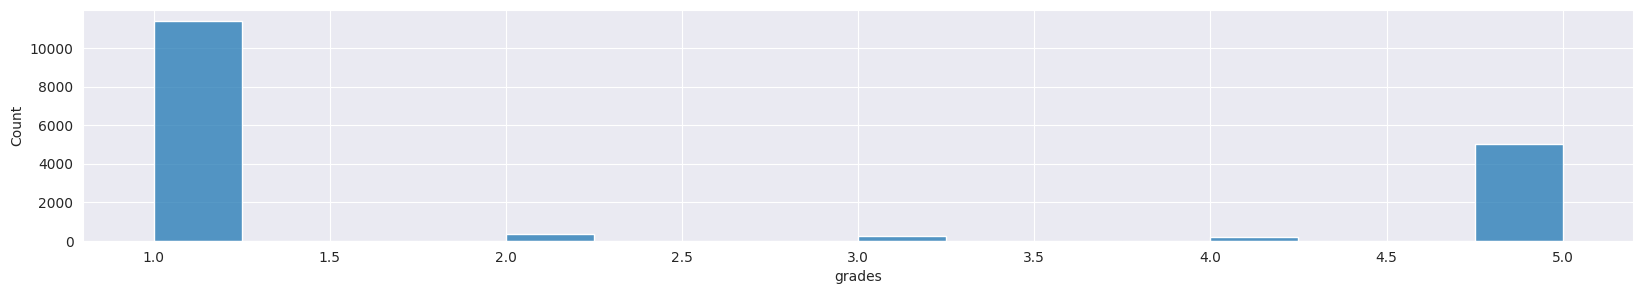

In [32]:
sol.grades.value_counts().sort_index()
plt.figure(figsize=(20, 3))
sns.histplot(data=df, x=sol.grades, )
plt.show()

In [87]:
sol.to_csv('new_baseline_result2.csv', index=False)

##Test##